# Project Final Report of Group 17

#### Github Link: https://github.com/Mantoj130/Data-Science-Project

## Introduction

Background: A research group in Computer Science at UBC, led by Frank Wood, is collecting data about how people play video games. They have set up a MineCraft server where players' in-game actions are recordered as they navigate through the world.These data allow researchers to study player behavior in a naturalistic online environment, with the goal of understanding how players engage with the game and what factors drive deeper participation. 

Using the collected dataset, we aim to address a set of broad research questions. One practical challenge the team faced is the need to target recruitment effectively and ensure enough resources to handle the number of players they attract. Among 3 broad questions, we focus on the following:

Broad Question 1: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

Specific Research Question: Can age and experience predict whether or not a player is subscribed to a game-related newsletter in the `players.csv` dataset?

For `player.csv` , there are 196 observations and 7 columns. This dataset provides static characteristics describing each player.
1. `experience`, character, describes player's level as: `Pro`, `Veteran`, `Amateur`, `Regular`, and `Beginner`.
2. `subscribe`, logical, describes whether the player subscribed to the game info as: `TRUE` or `FALSE`.
3. `hashedEmail`, character, describes the hashed email address of the player.
4. `played_hours`, double, describes the player's playtime on the server, ranging from 0 to 223.1.
5. `name`, character, describes the name of the player.
6. `gender`, character, describes the player's gender as: `male`, `female`, `Non-binary`, `Prefer not to say`, `Agender`, `Two-Spirited` and `Other`.
7. `Age`, double, describes the player's age, ranging from 9 to 58.

## Methods
To answer this question we decided to use K-nearest neighbours classification to predict whether or not a player was subscribed using player age and experience. This method is appropriate because we can turn player experience into quantitative variables using the natural ascending order, and it is unlikely from our initial exploration that there will be a linear association between the explanatory and response variables. There are also very little assumptions required, only that distance between points is correlated to their similarity, which makes this method easy to apply here. It is possible that as we increase training data the algorithm may slow down, and may not be applicable outside the range of our explanatory variables. But since the amount of observations is not too high, and our explanatory variables have natural boundaries (lifespan and preset categories) that prevent us from having to predict outside of our range, the weaknesses of this method should not limit the validity of our results. 

After cleaning the data of null values, fixing the colunm names, and turning the subscribe and experience column into variables that the algorithm can we work with, we split the data into testing and training subsets. Training took up 80% of the data, and the rest was used as testing to later evaluate the effectiveness our algorithm. Exploratory graphs of the experience, age, and subscription columns were created, showing no clear linear relation between any of the variables. RMSPE was then used to optimize the number of neighbours (K) with 10 fold cross validations and 5 repeats on the training subset. The algorithm was then evaluated using the testing subset, 

In [2]:
#Run these beforehand
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(gridExtra)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Results

In [4]:
#Loading and cleaning dataset
players <- read_csv("players.csv")
#fix column names
colnames(players) <- c("experience","subscribe", "hashed_email", "played_hours", "name", "gender", "age")
#filter out NA values
players <- players |> 
    filter(!is.na(age)) |>
    filter(!is.na(experience))
#add a numeric experience column
players$experience_numeric <- recode(players$experience, 
                          "Pro" = 5,
                          "Veteran" = 4, 
                          "Regular" = 3, 
                          "Amateur" = 2, 
                          "Beginner" = 1)
#add a factorized subscribed column
players$subscribe_factor <- factor(players$subscribe)

#mean(players$age)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


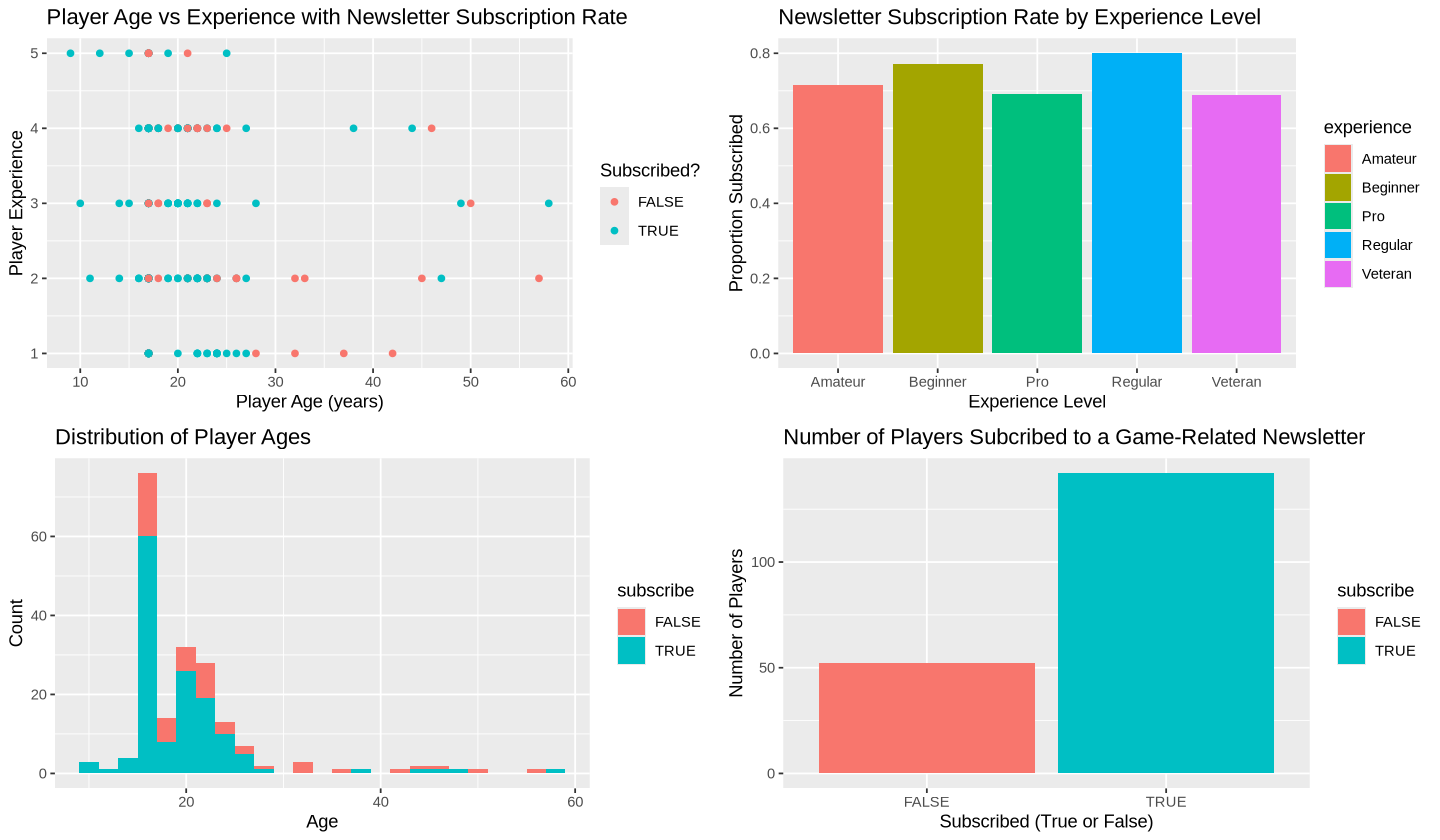

In [10]:
#exploration plots
options(repr.plot.width=12, repr.plot.height=7)
plot1 <- players |>
    ggplot(aes(x = age, y =  experience_numeric, colour = subscribe)) + 
        geom_point() +
        labs(x="Player Age (years)", y="Player Experience", colour="Subscribed?") +
        ggtitle("Player Age vs Experience with Newsletter Subscription Rate")
plot2 <- players |>
    group_by(experience) |>
    summarize(prop_subscribe = mean(subscribe)) |>
    ggplot(aes(x= experience, y=prop_subscribe, fill = experience)) +
    geom_col() +
    labs(title = "Newsletter Subscription Rate by Experience Level",
         x = "Experience Level",
         y = "Proportion Subscribed")
plot3 <- players |>
    ggplot(aes(x = age, fill = subscribe)) +
    geom_histogram(binwidth = 2) +
    labs(title = "Distribution of Player Ages",
            x = "Age", y = "Count")
plot4 <- players |>
    ggplot(aes(x = subscribe, fill = subscribe)) +
    geom_bar() +
    labs(x = "Subscribed (True or False)",
         y = "Number of Players",
         title = "Number of Players Subcribed to a Game-Related Newsletter")



grid.arrange(plot1, plot2, plot3, plot4, ncol = 2, widths = c(1,1))

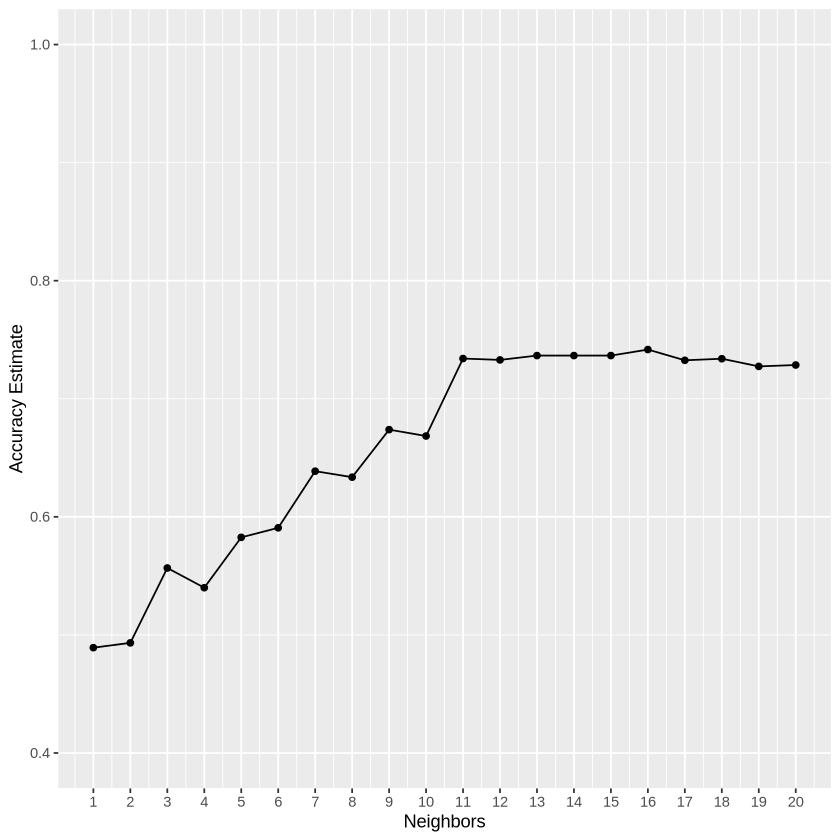

In [15]:
#Splitting dataset between training and testing
player_split <- initial_split(players, prop = 0.80, strata = subscribe_factor)  
player_train <- training(player_split)   
player_test <- testing(player_split)

#Setup classification
player_recipe <- recipe(subscribe_factor ~ age + experience_numeric, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
       set_engine("kknn") |>
       set_mode("classification") 
player_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(player_spec)

#Find most accurate nearest neighbours
player_vfold <- vfold_cv(player_train, v = 10, strata = subscribe_factor, repeats = 5)
gridvals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))
player_results <- player_workflow |> 
    tune_grid(resamples = player_vfold, grid = gridvals) |>
    collect_metrics()
accuracies <- player_results |> 
       filter(.metric == "accuracy")
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(1, 20, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k

In [16]:
#Select most accurate neighber and compare with testing dataset
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
       set_engine("kknn") |>
       set_mode("classification")
player_best_spec <- workflow() |>
       add_recipe(player_recipe) |>
       add_model(knn_spec)
player_fit <- fit(player_best_spec, data = player_train)
player_predictions <- predict(player_fit , player_test)|>
       bind_cols(player_test)
player_metrics <- player_predictions |>
         metrics(truth = subscribe_factor, estimate = .pred_class)
#print accuracy with predictions on testing dataset
player_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.70000000
kap,binary,0.02834008


## Discussion